# Virtual data set (VDS) reference file creation using Virtualizarr - Basic L2 dataset

Basic L2 dataset here refers to a dataset with just the 1D dimensions `along_track`, `cross_track`, which have the same sizes accross all files. The L2 dataset used in this notebook is SCATSAT1_ESDR_L2_WIND_STRESS_V1.1.

SCATSAT1_ESDR_L2_WIND_STRESS_V1.1 is an L2 data set with no time dimension, so this is an example of saving along a newly created dimension. We test combining the individual files along both a time dummy dim, and a "granule ID" dummy dim. A major question is how to structure the combined VDS to facilitate both temporal and spatial search at minimum. It would be fantastic to have spatial subset as well, but that is a much harder task.

#### **Results**
1. VDS's with both time and granule_ID dummy dims were successfully created.
2. Care must be taken when creating the combined VDS for either dummy dim. When calling `xr.concat(single_vds_refs_list)`, the kwarg `coords` should be passed a list of the lat, lon var names, e.g. `coords = [lat, lon]` so xarray knows to combine these "coords" along the new dimension. Otherwise, if `coords = minimal`, the lat, lon values of the first file will be used for all the combined files. For background, this happens because xarray is taking the lat, lon vars and turning them into coords. See Note 1 below.
3. If `2.` above is done correctly, the resulting VDS can be used with spatial search. The protocol is to first use earthaccess to find all granules in a desired bbox, then extract their starttimes using the granule metadata, then pass those values into the VDS to subset along the dummy time dimension (see Section 4 and 4.2.1). An analogous procedure would be used for the granule_ID dummy dim.

#### **Notes and Takeaways**
1. Xarray is trying to be too smart. It is using the CF-conventions to take the latitude, longitude variables and turn them into coordinates. This isn't necessarily a bad thing, but can lead to only the lat, lon values from the first file being used for the entire dataset - e.g. you have lat(along_track, cross_track) rather than the desired lat(along_track, cross_track, time). This can be avoided by being explicit about how to combine the coordinates in the call to `xarray.concat()`. This also brings up another point which is that in v1.x of virtualizarr, you cannot pass `decode_cf = False`, which would prevent the lat, lon vars from being turned into coordinates in the first place.

In [3]:
# Built-in packages
import os
import sys
import shutil

# Filesystem management 
import fsspec
import earthaccess

# Data handling
import numpy as np
import xarray as xr
from virtualizarr import open_virtual_dataset
import pandas as pd

# Parallel computing 
import multiprocessing
from dask import delayed
import dask.array as da
from dask.distributed import Client
from distributed.utils import silence_logging_cmgr
import coiled

# Other
import matplotlib.pyplot as plt

## 1. Get Data File S3 endpoints in Earthdata Cloud

In [4]:
# Get Earthdata creds
earthaccess.login()

Enter your Earthdata Login username:  deanh808
Enter your Earthdata password:  ········


In [5]:
# Get AWS creds. Note that if you spend more than 1 hour in the notebook, you may have to re-run this line!!!
fs = earthaccess.get_s3_filesystem(daac="PODAAC")

In [6]:
# Locate CCMP file information / metadata:
granule_info = earthaccess.search_data(
    short_name="SCATSAT1_ESDR_L2_WIND_STRESS_V1.1",
    count=100
    )

In [7]:
# Get S3 endpoints for all files:
data_s3links = [g.data_links(access="direct")[0] for g in granule_info]
print(len(data_s3links))
data_s3links[0:3]

100


['s3://podaac-ops-cumulus-protected/SCATSAT1_ESDR_L2_WIND_STRESS_V1.1/2018/091/measures_esdr_scatsat_l2_wind_stress_08002_v1.1_s20180401-011908-e20180401-025826.nc',
 's3://podaac-ops-cumulus-protected/SCATSAT1_ESDR_L2_WIND_STRESS_V1.1/2018/091/measures_esdr_scatsat_l2_wind_stress_08003_v1.1_s20180401-025826-e20180401-043745.nc',
 's3://podaac-ops-cumulus-protected/SCATSAT1_ESDR_L2_WIND_STRESS_V1.1/2018/091/measures_esdr_scatsat_l2_wind_stress_08004_v1.1_s20180401-043745-e20180401-061703.nc']

## 2. Generate single-orbit reference files

One file per orbit, so one reference file per orbit.

In [8]:
n_files_process = 100

In [9]:
# This will be assigned to 'loadable_variables' and needs to be modified per the specific 
# coord names of the data set:
coord_vars = ["along_track","cross_track"]

In [10]:
print("CPU count =", multiprocessing.cpu_count())

CPU count = 4


In [11]:
reader_opts = {"storage_options": fs.storage_options} # S3 filesystem creds from previous section.

In [12]:
# Start up cluster and print some information about it:
client = Client(n_workers=4, threads_per_worker=1)
print(client.cluster)
print("View any work being done on the cluster here", client.dashboard_link)

LocalCluster(b9eabf16, 'tcp://127.0.0.1:44949', workers=4, threads=4, memory=14.49 GiB)
View any work being done on the cluster here https://cluster-fnvlv.dask.host/jupyter/proxy/8787/status


2025-10-27 18:37:50,577 - distributed.scheduler - WARNING - Detected different `run_spec` for key 'original-open_dataset-wind_stress_magnitude-b331810497876e3bede64d6629aae589' between two consecutive calls to `update_graph`. This can cause failures and deadlocks down the line. Please ensure unique key names. If you are using a standard dask collections, consider releasing all the data before resubmitting another computation. More details and help can be found at https://github.com/dask/dask/issues/9888. 
Debugging information
---------------------
old task state: released
old run_spec: (<function execute_task at 0x7bc3c8e72a20>, (ImplicitToExplicitIndexingAdapter(array=CopyOnWriteArray(array=LazilyIndexedArray(array=_ElementwiseFunctionArray(LazilyIndexedArray(array=<xarray.backends.zarr.ZarrArrayWrapper object at 0x7bc35bd66800>, key=BasicIndexer((slice(None, None, None), slice(None, None, None), slice(None, None, None)))), func=functools.partial(<function _apply_mask at 0x7bc3cab574

In [13]:
%%time
# Create individual references:
open_vds_par = delayed(open_virtual_dataset)
tasks = [
    open_vds_par(p, indexes={}, reader_options=reader_opts, loadable_variables=coord_vars) 
    for p in data_s3links[:n_files_process]
    ]
virtual_ds_list = list(da.compute(*tasks)) # The xr.combine_nested() function below needs a list rather than a tuple.

CPU times: user 4.8 s, sys: 788 ms, total: 5.58 s
Wall time: 34 s


## 3. Generate combined reference files

Several combined reference files will be tried:
1. **Combine along a newly created time dimension:** The dimension will be "orbit start time", so get the start time from each file using the granule metadata. Convert those times into cf-compliant formats (e.g. "second since ...").
2. **Combine along a newly created granule ID dimension:** The dimension will be "granule ID", so get the granule ID from each file using the granule metadata.
3. **Combine along the along-track dimension:** This would be equivalent to having a single large file that continuously accumulated data as the satellite continued to orbit.

## 3.1 Combine along a newly created time dimension

In [14]:
## The dimension will be "orbit start time", so get the start time from each file using the granule metadata:

basetime_str = "1970-01-01T00:00:00Z" # times will be measured in seconds since this basetime. 

orbit_starttime_list = []
for g in granule_info[:n_files_process]:
    datetime_str = g['umm']['TemporalExtent']['RangeDateTime']['BeginningDateTime']
    datetime_obj = np.datetime64(datetime_str)
    basetime_obj = np.datetime64(basetime_str)
    timedelt = np.timedelta64(datetime_obj - basetime_obj, 's').astype(int)
    orbit_starttime_list.append(timedelt)

/tmp/ipykernel_647/904977041.py:8: UserWarning: no explicit representation of timezones available for np.datetime64
  datetime_obj = np.datetime64(datetime_str)
/tmp/ipykernel_647/904977041.py:9: UserWarning: no explicit representation of timezones available for np.datetime64
  basetime_obj = np.datetime64(basetime_str)


In [15]:
## Wrap the orbit start time data in an xarray.DataArray, assigning CF-aligned attributes:
orbit_starttime_da = xr.DataArray(
    data=orbit_starttime_list,
    name="orbit_start_time",
    dims=["orbit_start_time"],
    attrs=dict(
        units="seconds since " + basetime_str,
        calendar = "gregorian"
    )
)

In [37]:
%%time
# Create the combined reference
#virtual_ds_combined = xr.concat(virtual_ds_list, orbit_starttime_da, coords='minimal', compat='override', combine_attrs='drop_conflicts')
virtual_ds_combined = xr.concat(
    virtual_ds_list, orbit_starttime_da, 
    coords = ["lat", "lon"], compat='override', combine_attrs='drop_conflicts'
)

CPU times: user 487 ms, sys: 8.85 ms, total: 496 ms
Wall time: 488 ms


In [38]:
virtual_ds_combined

<xarray.Dataset> Size: 7GB
Dimensions:                        (orbit_start_time: 100, along_track: 3248,
                                    cross_track: 152)
Coordinates:
    lat                            (orbit_start_time, along_track, cross_track) float32 197MB ManifestArray<shape=(100, 3248, 152), dtype=float32, chunk...
    lon                            (orbit_start_time, along_track, cross_track) float32 197MB ManifestArray<shape=(100, 3248, 152), dtype=float32, chunk...
  * orbit_start_time               (orbit_start_time) int64 800B 1522545549 ....
Dimensions without coordinates: along_track, cross_track
Data variables: (12/34)
    real_wind_u_error              (orbit_start_time, along_track, cross_track) float32 197MB ManifestArray<shape=(100, 3248, 152), dtype=float32, chunk...
    flags                          (orbit_start_time, along_track, cross_track) int32 197MB ManifestArray<shape=(100, 3248, 152), dtype=int32, chunks=...
    quality_indicator              (orbit_start_time, along_track, cross_track) int16 99MB ManifestArray<shape=(100, 3248, 152), dtype=int16, chunks=(...
    en_wind_speed                  (orbit_start_time, along_track, cross_track) float32 197MB ManifestArray<shape=(100, 3248, 152), dtype=float32, chunk...
    wind_stress_u                  (orbit_start_time, along_track, cross_track) float32 197MB ManifestArray<shape=(100, 3248, 152), dtype=float32, chunk...
    en_wind_direction_error        (orbit_start_time, along_track, cross_track) float32 197MB ManifestArray<shape=(100, 3248, 152), dtype=float32, chunk...
    ...                             ...
    time                           (orbit_start_time, along_track) float64 3MB ManifestArray<shape=(100, 3248), dtype=float64, chunks=(1, 3248...
    en_wind_u_error                (orbit_start_time, along_track, cross_track) float32 197MB ManifestArray<shape=(100, 3248, 152), dtype=float32, chunk...
    en_wind_direction              (orbit_start_time, along_track, cross_track) float32 197MB ManifestArray<shape=(100, 3248, 152), dtype=float32, chunk...
    en_wind_u                      (orbit_start_time, along_track, cross_track) float32 197MB ManifestArray<shape=(100, 3248, 152), dtype=float32, chunk...
    rain_speed_bias                (orbit_start_time, along_track, cross_track) float32 197MB ManifestArray<shape=(100, 3248, 152), dtype=float32, chunk...
    nudge_wind_speed               (orbit_start_time, along_track, cross_track) float32 197MB ManifestArray<shape=(100, 3248, 152), dtype=float32, chunk...
Attributes: (12/27)
    Conventions:               CF-1.8, ACDD-1.3, ISO-8601
    ShortName:                 SCATSAT1_ESDR_L2_WIND_STRESS_V1.1
    creator_name:              Svetla Hristova-Veleva, Bryan Stiles, Alexande...
    creator_type:              institution
    geospatial_lat_max:        89.99N
    geospatial_lat_min:        -89.99N
    ...                        ...
    standard_name_vocabulary:  CF Standard Name Table v78
    summary:                   This project is funded by NASA’s Making Earth ...
    time_coverage_duration:    P0DT1H41M0S
    time_coverage_resolution:  P0DT0H0M30S
    title:                     SCATSAT-1 Scatterometer Inter-Calibrated ESDR ...
    version_id:                1.1

In [39]:
# Save in JSON and PARQUET formats:
fname_combined_json = 'ref_combined_SCATSAT1_ESDR_L2_WIND_STRESS_V1.1_concat-time.json'
fname_combined_parq = 'ref_combined_SCATSAT1_ESDR_L2_WIND_STRESS_V1.1_concat-time.parq'
virtual_ds_combined.virtualize.to_kerchunk(fname_combined_json, format='json')
virtual_ds_combined.virtualize.to_kerchunk(fname_combined_parq, format='parquet')

## 3.2 Combine along a newly created granule ID dimension

In [18]:
## Get the granule ID from each file using the granule metadata:
gran_id = [g['meta']['concept-id'] for g in granule_info]

In [19]:
## Wrap the orbit start time data in an xarray.DataArray, assigning CF-aligned attributes:
gran_id_da = xr.DataArray(
    data=gran_id,
    name="granule_id",
    dims=["granule_id"]
)

In [20]:
%%time
# Create the combined reference
virtual_ds_combined = xr.concat(virtual_ds_list, gran_id_da, coords='minimal', compat='override', combine_attrs='drop_conflicts')

CPU times: user 458 ms, sys: 1 ms, total: 459 ms
Wall time: 452 ms


In [21]:
virtual_ds_combined

<xarray.Dataset> Size: 6GB
Dimensions:                        (granule_id: 100, along_track: 3248,
                                    cross_track: 152)
Coordinates:
    lat                            (along_track, cross_track) float32 2MB ...
    lon                            (along_track, cross_track) float32 2MB ...
  * granule_id                     (granule_id) <U19 8kB 'G2915919268-POCLOUD...
Dimensions without coordinates: along_track, cross_track
Data variables: (12/34)
    real_wind_u_error              (granule_id, along_track, cross_track) float32 197MB ManifestArray<shape=(100, 3248, 152), dtype=float32, chunks=(1, ...
    flags                          (granule_id, along_track, cross_track) int32 197MB ManifestArray<shape=(100, 3248, 152), dtype=int32, chunks=(1, 32...
    quality_indicator              (granule_id, along_track, cross_track) int16 99MB ManifestArray<shape=(100, 3248, 152), dtype=int16, chunks=(1, 324...
    en_wind_speed                  (granule_id, along_track, cross_track) float32 197MB ManifestArray<shape=(100, 3248, 152), dtype=float32, chunks=(1, ...
    wind_stress_u                  (granule_id, along_track, cross_track) float32 197MB ManifestArray<shape=(100, 3248, 152), dtype=float32, chunks=(1, ...
    en_wind_direction_error        (granule_id, along_track, cross_track) float32 197MB ManifestArray<shape=(100, 3248, 152), dtype=float32, chunks=(1, ...
    ...                             ...
    time                           (granule_id, along_track) float64 3MB Mani...
    en_wind_u_error                (granule_id, along_track, cross_track) float32 197MB ManifestArray<shape=(100, 3248, 152), dtype=float32, chunks=(1, ...
    en_wind_direction              (granule_id, along_track, cross_track) float32 197MB ManifestArray<shape=(100, 3248, 152), dtype=float32, chunks=(1, ...
    en_wind_u                      (granule_id, along_track, cross_track) float32 197MB ManifestArray<shape=(100, 3248, 152), dtype=float32, chunks=(1, ...
    rain_speed_bias                (granule_id, along_track, cross_track) float32 197MB ManifestArray<shape=(100, 3248, 152), dtype=float32, chunks=(1, ...
    nudge_wind_speed               (granule_id, along_track, cross_track) float32 197MB ManifestArray<shape=(100, 3248, 152), dtype=float32, chunks=(1, ...
Attributes: (12/27)
    Conventions:               CF-1.8, ACDD-1.3, ISO-8601
    ShortName:                 SCATSAT1_ESDR_L2_WIND_STRESS_V1.1
    creator_name:              Svetla Hristova-Veleva, Bryan Stiles, Alexande...
    creator_type:              institution
    geospatial_lat_max:        89.99N
    geospatial_lat_min:        -89.99N
    ...                        ...
    standard_name_vocabulary:  CF Standard Name Table v78
    summary:                   This project is funded by NASA’s Making Earth ...
    time_coverage_duration:    P0DT1H41M0S
    time_coverage_resolution:  P0DT0H0M30S
    title:                     SCATSAT-1 Scatterometer Inter-Calibrated ESDR ...
    version_id:                1.1

In [22]:
# Save in JSON and PARQUET formats:
fname_combined_json = 'ref_combined_SCATSAT1_ESDR_L2_WIND_STRESS_V1.1_concat-granid.json'
fname_combined_parq = 'ref_combined_SCATSAT1_ESDR_L2_WIND_STRESS_V1.1_concat-granid.parq'
virtual_ds_combined.virtualize.to_kerchunk(fname_combined_json, format='json')
virtual_ds_combined.virtualize.to_kerchunk(fname_combined_parq, format='parquet')

## 3.3 Generate combined reference file along `along_track` dimension

**So far, running the code to create the combined reference file hangs up indefinitely.**

In [48]:
%%time
# Create the combined reference
virtual_ds_combined = xr.combine_nested(virtual_ds_list, concat_dim='along_track', coords='minimal', compat='override', combine_attrs='drop_conflicts')
#virtual_ds_combined = xr.concat(virtual_ds_list, 'along_track', coords='minimal', compat='override', combine_attrs='drop_conflicts')

Exception ignored in: <function File.close at 0x7f1d283bde40>
Traceback (most recent call last):
  File "/opt/coiled/env/lib/python3.12/site-packages/h5netcdf/core.py", line 1676, in close
    if not self._closed:
           ^^^^^^^^^^^^
AttributeError: 'File' object has no attribute '_closed'

KeyboardInterrupt



## 4. Test reference files

The primary objective is to be able to do both temporal and spatial search with the same VDS. The hope is that temporal and spatial search with the `earthaccess` package can be translated to subsetting along one or more of the VDS dims.

## 4.1 First confirm that spatial search is working as expected in earthaccess for the native netCDF's

Temporal search is assumed to work, spatial search is the trickier one. Want to verify that earthaccess is accurately finding all granules in a given bounding box.

In [19]:
bbox_pm180 = (-20, -20, 0, 0)  # bounding box over longitude range -180, 180.
bbox_0360 = (340, -20, 360, 0)  # bounding box over longitude range 0, 360.
bbox_width = bbox_0360[2] - bbox_0360[0]
bbox_height = bbox_0360[3] - bbox_0360[1]

In [20]:
# Locate granule metadata in bbox of interest:
granule_info_bbox = earthaccess.search_data(
    short_name="SCATSAT1_ESDR_L2_WIND_STRESS_V1.1",
    bounding_box = bbox_pm180,
    count=10
    )

In [21]:
fileobjs_bbox = earthaccess.open(granule_info_bbox)

QUEUEING TASKS | :   0%|          | 0/10 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/10 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/10 [00:00<?, ?it/s]

In [40]:
datetimes_str = [g['umm']['TemporalExtent']['RangeDateTime']['BeginningDateTime'] for g in granule_info_bbox]
datetimes_obj = [np.datetime64(dts) for dts in datetimes_str]

/tmp/ipykernel_647/998139349.py:2: UserWarning: no explicit representation of timezones available for np.datetime64
  datetimes_obj = [np.datetime64(dts) for dts in datetimes_str]


CPU times: user 984 ms, sys: 106 ms, total: 1.09 s
Wall time: 1.67 s


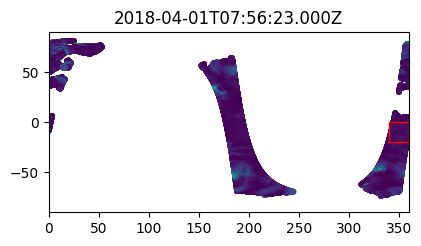

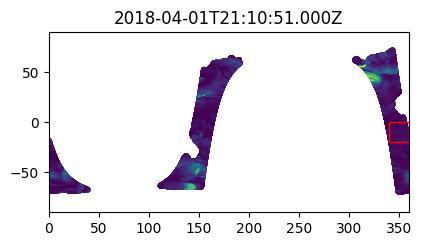

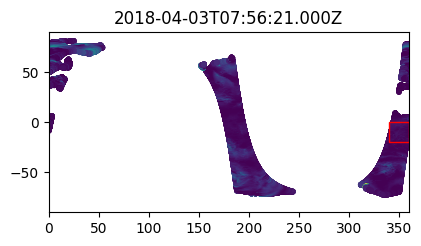

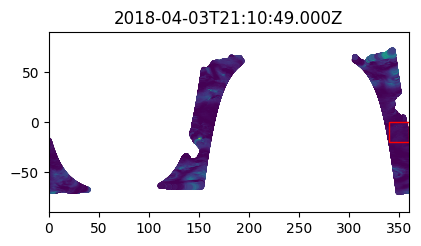

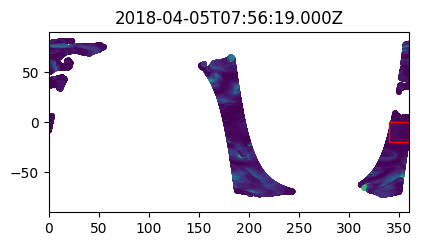

In [48]:
%%time

n_plot = 5
figs = [plt.figure(figsize=(4,2)) for n in range(n_plot)]
axes = [f.add_axes((0, 0, 0.9, 0.9)) for f in figs]

for fo, ax, dts in zip(fileobjs_bbox[:n_plot], axes, datetimes_str[:n_plot]):
    data = xr.open_dataset(fo)
    bbox_patch = plt.Rectangle(
        (bbox_0360[0], bbox_0360[1]), bbox_width, bbox_height, 
        edgecolor='red', facecolor='none'
    )
    ax.add_patch(bbox_patch)
    ax.set_title(dts)
    ax.scatter(
        data['lon'], data['lat'], c=data['wind_stress_magnitude'], 
        marker='.', zorder=-99, vmin=0, vmax=1.5
    )
    ax.set_xlim([0, 360])
    ax.set_ylim([-90, 90])

## 4.2 Test spatial search with VDS's

In [43]:
def opends_withref(ref, fs_data):
    """
    "ref" is a reference file or object. "fs_data" is a filesystem with credentials to
    access the actual data files. 
    """
    storage_opts = {"fo": ref, "remote_protocol": "s3", "remote_options": fs_data.storage_options}
    fs_ref = fsspec.filesystem('reference', **storage_opts)
    m = fs_ref.get_mapper('')
    data = xr.open_dataset(
        m, engine="zarr", chunks={},
        backend_kwargs={"consolidated": False}
    )
    return data

## 4.2.1 VDS with added time dimension 

In [44]:
%%time
data_vds = opends_withref('ref_combined_SCATSAT1_ESDR_L2_WIND_STRESS_V1.1_concat-time.json', fs)
data_vds

CPU times: user 123 ms, sys: 23.2 ms, total: 146 ms
Wall time: 464 ms


<xarray.Dataset> Size: 7GB
Dimensions:                        (orbit_start_time: 100, along_track: 3248,
                                    cross_track: 152)
Coordinates:
    lat                            (orbit_start_time, along_track, cross_track) float32 197MB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    lon                            (orbit_start_time, along_track, cross_track) float32 197MB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
  * orbit_start_time               (orbit_start_time) datetime64[ns] 800B 201...
Dimensions without coordinates: along_track, cross_track
Data variables: (12/34)
    cross_track_wind_speed_bias    (orbit_start_time, along_track, cross_track) float32 197MB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    distance_from_coast            (orbit_start_time, along_track, cross_track) float32 197MB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    en_wind_direction              (orbit_start_time, along_track, cross_track) float32 197MB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    en_wind_direction_error        (orbit_start_time, along_track, cross_track) float32 197MB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    en_wind_direction_uncorrected  (orbit_start_time, along_track, cross_track) float32 197MB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    en_wind_speed                  (orbit_start_time, along_track, cross_track) float32 197MB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    ...                             ...
    wind_stress_magnitude          (orbit_start_time, along_track, cross_track) float32 197MB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    wind_stress_magnitude_error    (orbit_start_time, along_track, cross_track) float32 197MB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    wind_stress_u                  (orbit_start_time, along_track, cross_track) float32 197MB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    wind_stress_u_error            (orbit_start_time, along_track, cross_track) float32 197MB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    wind_stress_v                  (orbit_start_time, along_track, cross_track) float32 197MB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    wind_stress_v_error            (orbit_start_time, along_track, cross_track) float32 197MB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
Attributes: (12/27)
    Conventions:               CF-1.8, ACDD-1.3, ISO-8601
    ShortName:                 SCATSAT1_ESDR_L2_WIND_STRESS_V1.1
    creator_name:              Svetla Hristova-Veleva, Bryan Stiles, Alexande...
    creator_type:              institution
    geospatial_lat_max:        89.99N
    geospatial_lat_min:        -89.99N
    ...                        ...
    standard_name_vocabulary:  CF Standard Name Table v78
    summary:                   This project is funded by NASA’s Making Earth ...
    time_coverage_duration:    P0DT1H41M0S
    time_coverage_resolution:  P0DT0H0M30S
    title:                     SCATSAT-1 Scatterometer Inter-Calibrated ESDR ...
    version_id:                1.1

In [45]:
data_vds_bbox = data_vds.sel(orbit_start_time = datetimes_obj)
data_vds_bbox

<xarray.Dataset> Size: 711MB
Dimensions:                        (orbit_start_time: 10, along_track: 3248,
                                    cross_track: 152)
Coordinates:
    lat                            (orbit_start_time, along_track, cross_track) float32 20MB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    lon                            (orbit_start_time, along_track, cross_track) float32 20MB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
  * orbit_start_time               (orbit_start_time) datetime64[ns] 80B 2018...
Dimensions without coordinates: along_track, cross_track
Data variables: (12/34)
    cross_track_wind_speed_bias    (orbit_start_time, along_track, cross_track) float32 20MB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    distance_from_coast            (orbit_start_time, along_track, cross_track) float32 20MB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    en_wind_direction              (orbit_start_time, along_track, cross_track) float32 20MB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    en_wind_direction_error        (orbit_start_time, along_track, cross_track) float32 20MB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    en_wind_direction_uncorrected  (orbit_start_time, along_track, cross_track) float32 20MB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    en_wind_speed                  (orbit_start_time, along_track, cross_track) float32 20MB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    ...                             ...
    wind_stress_magnitude          (orbit_start_time, along_track, cross_track) float32 20MB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    wind_stress_magnitude_error    (orbit_start_time, along_track, cross_track) float32 20MB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    wind_stress_u                  (orbit_start_time, along_track, cross_track) float32 20MB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    wind_stress_u_error            (orbit_start_time, along_track, cross_track) float32 20MB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    wind_stress_v                  (orbit_start_time, along_track, cross_track) float32 20MB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    wind_stress_v_error            (orbit_start_time, along_track, cross_track) float32 20MB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
Attributes: (12/27)
    Conventions:               CF-1.8, ACDD-1.3, ISO-8601
    ShortName:                 SCATSAT1_ESDR_L2_WIND_STRESS_V1.1
    creator_name:              Svetla Hristova-Veleva, Bryan Stiles, Alexande...
    creator_type:              institution
    geospatial_lat_max:        89.99N
    geospatial_lat_min:        -89.99N
    ...                        ...
    standard_name_vocabulary:  CF Standard Name Table v78
    summary:                   This project is funded by NASA’s Making Earth ...
    time_coverage_duration:    P0DT1H41M0S
    time_coverage_resolution:  P0DT0H0M30S
    title:                     SCATSAT-1 Scatterometer Inter-Calibrated ESDR ...
    version_id:                1.1

CPU times: user 1.07 s, sys: 134 ms, total: 1.2 s
Wall time: 4.27 s


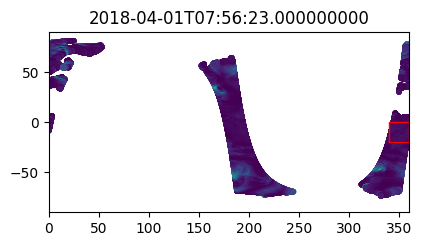

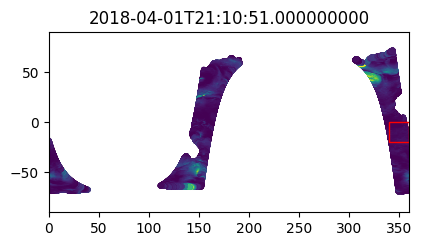

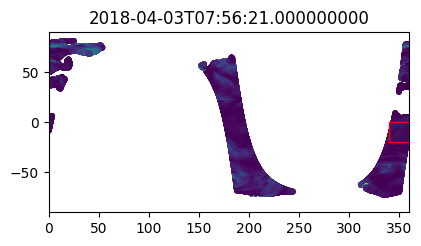

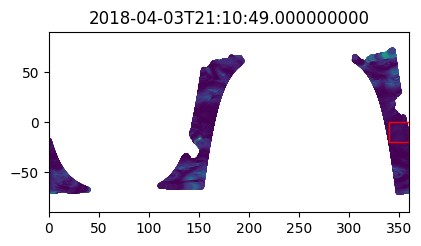

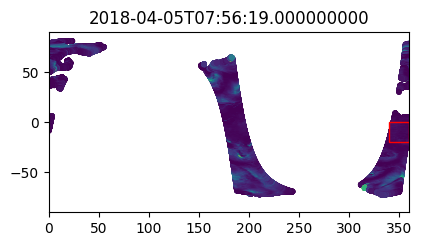

In [47]:
%%time

n_plot = 5
figs = [plt.figure(figsize=(4,2)) for n in range(n_plot)]
axes = [f.add_axes((0, 0, 0.9, 0.9)) for f in figs]

for ax, dt in zip(axes, data_vds_bbox["orbit_start_time"].values[:n_plot]):
    data_sub = data_vds_bbox.sel(orbit_start_time = dt)
    bbox_patch = plt.Rectangle(
        (bbox_0360[0], bbox_0360[1]), bbox_width, bbox_height, 
        edgecolor='red', facecolor='none'
    )
    ax.add_patch(bbox_patch)
    ax.set_title(dt)
    ax.scatter(
        data_sub['lon'], data_sub['lat'], c=data_sub['wind_stress_magnitude'], 
        marker='.', zorder=-99, vmin=0, vmax=1.5
    )
    ax.set_xlim([0, 360])
    ax.set_ylim([-90, 90])

## 4.3 Test computation (in construction)
Try doing a spatials search, then computing the mean wind speed time series over all found granules from the search.

In [10]:
%%time
#data.sel(orbit_start_time=slice(starttime, endtime))["real_wind_speed"].mean().compute()
ts = data.sel(granule_id=gran_id_bbox)["real_wind_speed"].mean(dim=["along_track","cross_track"]).compute()

CPU times: user 258 ms, sys: 27.5 ms, total: 285 ms
Wall time: 578 ms


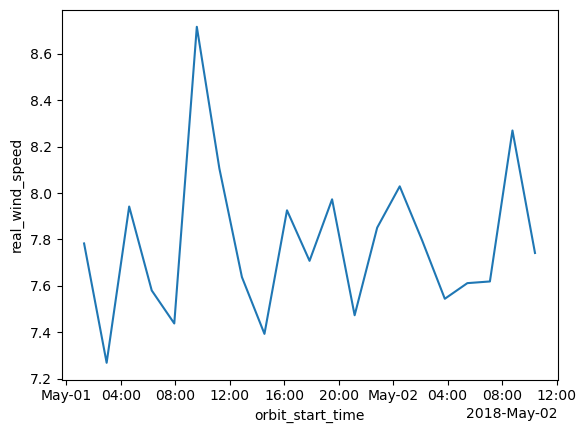

In [11]:
ts.plot()